In [11]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # "0,1,2,3" # "0"

In [12]:
import torch
import numpy as np
import h5py
import cv2
import PIL
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def save_eps(img,path):
    if type(img) == torch.Tensor:
        img = img.cpu().numpy()
    img = (img-img.min())/(img.max()-img.min())
    img = PIL.Image.fromarray((img*255).astype('uint8'))
    img.save(path,dpi=(300,300),mode='EPS')

In [14]:
folder_name = "./N2N_output_230917_wholeimg"
os.makedirs(folder_name, exist_ok=True)


In [15]:
def load_img_dict(target_x,target_y,debug=True):
    possible_f_num = ['F01','F02','F04','F08','F16','F32']
    x_f_num = []
    if target_x == 'F#':
        for f_num in possible_f_num:
            if f_num != target_y:
                x_f_num.append(f_num)
            else :
                break
    else :
        x_f_num = [target_x]
    x_f_num.append('F32')
    x_f_num.append('F64')
    print(x_f_num)
    img_dict = {}
    path_list = ["/home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung_SNU",
                 "/home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung+SNU+dataset+221115"
                 ]
    # data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned_ordered/" 
    debug = True
    for data_path in path_list:
        print("=====",data_path, "=====")
        for set_num in sorted(os.listdir(data_path)):
            if set_num[0] == '.' :
                continue
            set_path = os.path.join(data_path,set_num)
            set_number = int(set_num.split(" ")[-1][:-1])
            set_num = f"{set_num[1:4]}{set_number:02d}"
            print("=====",set_num, "=====")
            img_dict[set_num] = {}
            # if debug is True:
            #     print(set_num)
            f_num_list = os.listdir(set_path)
            print(f_num_list)
            for f_num in f_num_list:
                f_path = os.path.join(set_path,f_num)
                f_number = int(f_num[1:])
                f_num = f"F{f_number:02d}"
                # print(set_num,f_num)
                if f_num not in x_f_num:
                    print(f_num , " is not in ", x_f_num)
                    continue
                # img_dict[set_num][f_num] = None
                img_dict[set_num][f_num] = {}
                img_list = sorted(os.listdir(f_path))
                img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
                
                for filename in sorted(img_list):
                    
                    img_path = os.path.join(f_path,filename)
                    image_idx = int(filename.split("_")[0])
                    filename = f"{set_num}_{f_num}_{image_idx:02d}.png"
                    if debug is True:
                        print(f_num," & ",filename)
                    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) 
                    # img_dict[set_num][f_num].append(img)
                    # img = np.expand_dims(img,axis=0)
                    img = np.expand_dims(img,axis=0) / 255.
                    img_dict[set_num][f_num][filename] = img
                    # if img_dict[set_num][f_num] is None:  
                    #     img_dict[set_num][f_num] = img
                    # else :
                    #     img_dict[set_num][f_num] = np.append(img_dict[set_num][f_num],img,axis=0)
                    if debug is True:
                        print(set_num,f_num,img.shape)
    if debug is True:
        print(img_dict.keys())
        for set_num in img_dict.keys():
            print(" ",img_dict[set_num].keys())
            for f_num in img_dict[set_num].keys():
                print("   ",img_dict[set_num][f_num].keys())
    print("====== load img_dict complete ======")
    return img_dict
                        

In [16]:
img_dict = load_img_dict('F01','F02',debug=True)

['F01', 'F32', 'F64']
===== /home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung_SNU =====
===== SET01 =====
['F32', 'F8', 'F64', 'F16']
F32  &  SET01_F32_10.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_11.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_12.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_13.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_14.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_15.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_16.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_01.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_02.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_03.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_04.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_05.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_06.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_07.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_08.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_09.png
SET01 F32 (1, 2048, 3072)
F08  is not in  ['F01', 'F32', 'F64']


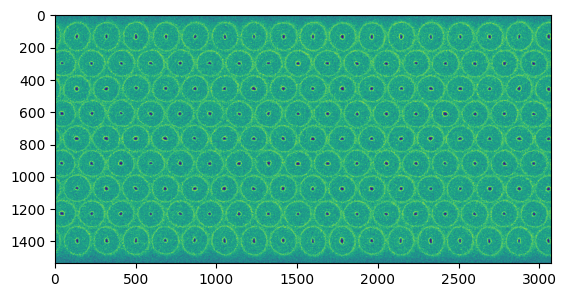

In [17]:
plt.imshow(img_dict['SET06']['F01']['SET06_F01_01.png'][0][256:-256,])

In [18]:
img_shape = img_dict['SET06']['F01']['SET06_F01_01.png'][0][256:-256,].shape
img_shape

(1536, 3072)

In [19]:
for val in img_shape:
    print(val/256)

6.0
12.0


In [20]:

import itertools
def get_fbi_weight(f_num_list = ['F#','F01','F02','F04','F08','F16','F32','F64'],loss = 'MSE_Affine',filter_keyword = ['median']):
    comb = list(itertools.combinations(f_num_list,2))
    total_fbi_weight_list = {}
    for x_f_num,y_f_num in comb:
        fbi_weight_list = glob(f"../weights/230*_FBI_Net*x_as_{x_f_num}*y_as_{y_f_num}*{loss}*")
        for keyword in filter_keyword:
            fbi_weight_list = list(filter(lambda x : keyword not in x,fbi_weight_list))
        total_fbi_weight_list += sorted(list(fbi_weight_list))
        print(x_f_num,y_f_num)
        for fbi_weight in fbi_weight_list:
            print(fbi_weight)
    return total_fbi_weight_list

In [22]:
gc.collect()
debug= True
partial_check = True

target_fbi_weight = [
    "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F02_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F08_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    '../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910individual_x_as_F01_y_as_F32_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
    # "../weights/230407_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F64_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230330_FBI_Net_Grayscale_Samsung_SET050607080910_mixed_x_as_F#_y_as_F04_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
    "../weights/230831_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F64_EMSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230702_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F64_N2V_layers_x17_filters_x64_cropsize_256.w",
    
    '../weights/230911_FBI_Net_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F#_MSE_Affine_layers_x17_filters_x64_cropsize_256.w',
    '../weights/230911_NAFNet_light_Grayscale_Samsung_SET050607080910_x_as_F01_y_as_F#_MSE_Affine_layers.w'
    
]


In [23]:


def parsing_weight_name(fbi_weight_dir):
    target_y = fbi_weight_dir.split("_y_as_")[1].split("_")[0]
    if "x_as_" in fbi_weight_dir:
        target_x = fbi_weight_dir.split("x_as_")[1][:3]
        if 'F#' in target_x:
            target_x = "F#"
    else :
        target_x = "F#"
    dataset_version = 'v1' if 'with_SET01020304' in fbi_weight_dir else 'v2'
    if "l1_on_img_gradient" in fbi_weight_dir:
        lambda_val = fbi_weight_dir.split("l1_on_img_gradient_")[1].split("_")[0]
        dataset_version += f"_l1_on_img_gradient_{lambda_val}"
    arch = "_".join(fbi_weight_dir.split("_")[1:3])
    loss_function = fbi_weight_dir.split(f"y_as_{target_y}_")[1].split("_layers")[0]
    return target_x,target_y, arch,loss_function


In [24]:

for weight_idx,fbi_weight_dir in enumerate(target_fbi_weight):

    target_x,target_y, arch, loss_func = parsing_weight_name(fbi_weight_dir)
    print(target_x,target_y, arch, loss_func)

F01 F02 FBI_Net MSE_Affine
F01 F04 FBI_Net MSE_Affine
F01 F08 FBI_Net MSE_Affine
F# F64 FBI_Net MSE_Affine
F01 F64 FBI_Net EMSE_Affine
F01 F64 FBI_Net N2V
F01 F# FBI_Net MSE_Affine
F01 F# NAFNet_light MSE_Affine


In [25]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
# args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
# args.model_type = 'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [34]:
from re import T
from core.utils import get_PSNR,get_SSIM


    
debug = False
imshow = False
metric = {}
for weight_idx,fbi_weight_dir in enumerate(target_fbi_weight):

    target_x,target_y, arch, loss_func = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    # key = f"{target_x}-{target_y}_{dataset_version}"
    key = f"{target_x}-{target_y}_{arch}"
    if loss_func != 'MSE_Affine':
        key += f"_{loss_func}"
    
    model_img_path = f"{folder_name}/{key}"
    os.makedirs(model_img_path,exist_ok=True)
    args.loss_function = loss_func
    args.model_type = arch
    if args.loss_function == 'EMSE_Affine':
        args.pge_weight_dir = "../weights/230914_PGE_Net_Noise_est_Grayscale_N2N_F01-F01_Samsung_Noise_est_cropsize_256_vst_MSE.w"
    else :
        args.pge_weight_dir = None
    print(f"========= {key}  & {loss_func }=========")
    
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    if target_x == 'F#':
        f_num = 'F01'
    else :
        f_num = target_x
        
    if f_num in ['F08','F16','F32','F64']:
        set_num_list = ['SET01','SET02','SET03','SET04','SET05','SET06','SET07','SET08','SET09','SET10']
    else :
        set_num_list = ['SET05','SET06','SET07','SET08','SET09','SET10'] # ['SET06']#
    if weight_idx == 0:
        metric['median_filter'] = {
            'PSNR' : [],
            'SSIM' : []
        }
        metric['raw'] = {
                'PSNR' : {},
                'SSIM' : {}
            }
        # metric['bm3d'] = {
        #     'PSNR' : [],
        #     'SSIM' : []
        # }
    metric[key] = {'before_PSNR' : {},
            'before_SSIM' : {},
            'PSNR' : {},
            'SSIM' : {}
        }
    print(set_num_list)
    for set_num in img_dict.keys():
        for f_num in [f_num]:
            if f_num in ['F01','F02','F04'] and set_num in ['SET01','SET02','SET03','SET04']:
                continue
            
                # print(f"Since F#, f_num : {f_num} Start")
            print(f"Denoising SET : {set_num}, f_num : {f_num} Start")
            for idx,(filename, img) in enumerate(img_dict[set_num][f_num].items()):
                img = img[:,256:-256] # 1536x3074
                img = np.expand_dims(img, axis=0) # 1,2990, 3072 
                F32_img = img_dict[set_num]['F32'][filename.replace(f_num,'F32')][0]
                F32_img = F32_img[256:-256]
                clean_img = img_dict[set_num]['F64'][filename.replace(f_num,'F64')][0]
                clean_img = clean_img[256:-256]
                
                print(filename,set_num,f_num,idx,img.shape)
                denoised_img = np.zeros(img.shape[2:])
                print(img.shape,denoised_img.shape)
                for x in range(0,img.shape[2],256):
                    for y in range(0,img.shape[3],256):
                        patch_denoised_img = model.eval(img[:,:,x:x+256,y:y+256])[0][0]
                        denoised_img[x:x+256,y:y+256] = patch_denoised_img
                # denoised_img = model.eval(img)[0][0]
                img = img[0][0]
                metric[key]['PSNR'][filename.split(".")[0]] = get_PSNR(clean_img,denoised_img)
                metric[key]['SSIM'][filename.split(".")[0]] = get_SSIM(clean_img,denoised_img)
                
                if os.path.exists(f"{model_img_path}/{filename}") is False:
                    print("imwrite : ",f"{model_img_path}/{filename}")
                    if type(denoised_img) == torch.Tensor:
                        denoised_img = denoised_img.cpu().detach().numpy()
                    cv2.imwrite(f"{model_img_path}/{filename}",denoised_img[0]*255)
                
                if weight_idx == 0:
                    metric['raw']['PSNR'][filename.split(".")[0]] = get_PSNR(clean_img,img)
                    metric['raw']['SSIM'][filename.split(".")[0]] = get_SSIM(clean_img,img)
                
                    medianfilterd_img = apply_median_filter_gpu_simple(img)[0][0]
                    median_psnr, median_ssim =  get_PSNR(clean_img,medianfilterd_img), get_SSIM(clean_img,medianfilterd_img)
                    metric['median_filter']['PSNR'].append(median_psnr)
                    metric['median_filter']['SSIM'].append(median_ssim)
                    
                    if set_num == 'SET06' and idx == 0:
                        filename = f"{folder_name}/F32.eps"
                        if os.path.exists(filename) is False:
                            save_eps(F32_img,filename)
                        filename = f"{folder_name}/median_filter_f32.eps"
                        if os.path.exists(filename) is False:
                            save_eps(medianfilterd_img,filename)
                    
            print(f"Denoising SET : {set_num}, f_num : {f_num} End")
    del model
    gc.collect()


========= F01-F02_FBI_Net  & MSE_Affine=========
['SET05', 'SET06', 'SET07', 'SET08', 'SET09', 'SET10']
Denoising SET : SET10, f_num : F01 Start
SET10_F01_01.png SET10 F01 0 (1, 1, 1536, 3072)
(1, 1, 1536, 3072) (1536, 3072)
SET10_F01_02.png SET10 F01 1 (1, 1, 1536, 3072)
(1, 1, 1536, 3072) (1536, 3072)
Denoising SET : SET10, f_num : F01 End
Denoising SET : SET05, f_num : F01 Start
SET05_F01_01.png SET05 F01 0 (1, 1, 1536, 3072)
(1, 1, 1536, 3072) (1536, 3072)
SET05_F01_02.png SET05 F01 1 (1, 1, 1536, 3072)
(1, 1, 1536, 3072) (1536, 3072)
Denoising SET : SET05, f_num : F01 End
Denoising SET : SET06, f_num : F01 Start
SET06_F01_01.png SET06 F01 0 (1, 1, 1536, 3072)
(1, 1, 1536, 3072) (1536, 3072)
SET06_F01_02.png SET06 F01 1 (1, 1, 1536, 3072)
(1, 1, 1536, 3072) (1536, 3072)
Denoising SET : SET06, f_num : F01 End
Denoising SET : SET07, f_num : F01 Start
SET07_F01_01.png SET07 F01 0 (1, 1, 1536, 3072)
(1, 1, 1536, 3072) (1536, 3072)
SET07_F01_02.png SET07 F01 1 (1, 1, 1536, 3072)
(1, 1, 

In [39]:
refined_metric = {}
for key in metric.keys():
    # print(key)
    refined_metric[key] = {}
    for sub_key in metric[key].keys():     
        # print(key,sub_key)
        if type(metric[key][sub_key]) == dict:
            metric[key][sub_key] = list(metric[key][sub_key].values())
        refined_metric[key][f'{sub_key}'] = np.mean(metric[key][sub_key])
        

import pandas as pd
refined_metric = pd.DataFrame(refined_metric)
refined_metric


/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,median_filter,raw,F01-F02_FBI_Net,F01-F04_FBI_Net,F01-F08_FBI_Net,F#-F64_FBI_Net,F01-F64_FBI_Net_EMSE_Affine,F01-F64_FBI_Net_N2V,F01-F#_FBI_Net,F01-F#_NAFNet_light
PSNR,17.663545,11.528837,16.686416,16.996637,17.604917,18.021731,15.811734,15.544972,17.240418,17.153796
SSIM,0.357408,0.021546,0.341123,0.347270,0.345357,0.343815,0.088771,0.094523,0.344314,0.343329
before_PSNR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
before_SSIM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
refined_metric.drop(['before_PSNR','before_SSIM'],inplace=True)
refined_metric

,median_filter,raw,F01-F02_FBI_Net,F01-F04_FBI_Net,F01-F08_FBI_Net,F#-F64_FBI_Net,F01-F64_FBI_Net_EMSE_Affine,F01-F64_FBI_Net_N2V,F01-F#_FBI_Net,F01-F#_NAFNet_light
PSNR,17.663545,11.528837,16.686416,16.996637,17.604917,18.021731,15.811734,15.544972,17.240418,17.153796
SSIM,0.357408,0.021546,0.341123,0.347270,0.345357,0.343815,0.088771,0.094523,0.344314,0.343329


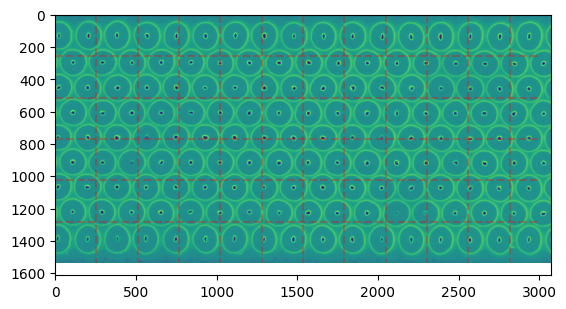

In [53]:

plt.imshow(denoised_img)
plt.hlines(range(256,1536,256),0,2990,colors='r',linestyles='dashed',alpha=0.3)
plt.vlines(range(256,2990,256),0,1536,colors='r',linestyles='dashed',alpha=0.3)

In [36]:
refined_metric.to_csv(f"{folder_name}/metric_whole_divide.csv")

In [38]:
from knockknock import telegram_sender
@telegram_sender(token='1531143270:AAFTord-4Bi370ohc39wGyYhjGi7_VjZTwU', chat_id=1597147353)
def denoising_end():
    print("Denoising End")
denoising_end()
!date

Denoising End
Wed Sep 27 07:03:01 UTC 2023
